Sihamdi Mostefa,Benaskeur moussabe

# Practical work 7: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [56]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()


    
def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [57]:
def quantize(I, k):
    """ float -> int 
    """
    if I==1:
        return k-1
    else:
        return int(I*k)


# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [58]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    Iq=np.zeros((I.shape)).astype(int)
    for i in range (Iq.shape[0]):
        for j in range (Iq.shape[1]):
            Iq[i,j,0]=quantize(I[i,j,0], nH)
            Iq[i,j,1]=quantize(I[i,j,1], nS)
            Iq[i,j,2]=quantize(I[i,j,2], nV)
    
    hist=np.zeros((nH, nS, nV))
    
    for i in range(Iq.shape[0]):
        for j in range(Iq.shape[1]):
            hist[Iq[i,j,0],Iq[i,j,1],Iq[i,j,2]]+=1
            
    return Iq,hist


3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [59]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


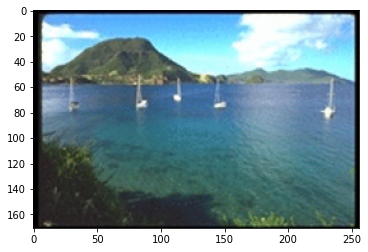

239.0625


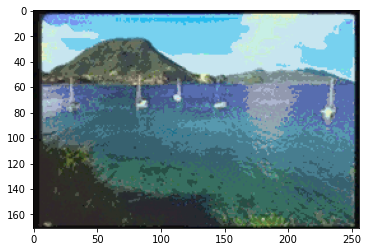

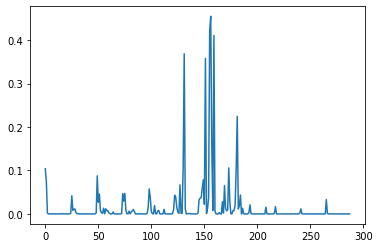

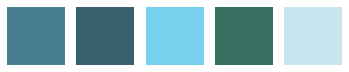

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [60]:
def HSV(nH,nS,nV,PathImage,nom):
    filename= nom;
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]
    plt.figure();
    plt.imshow(I);
    plt.show()

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors( nH, nS , nV );

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    viewQuantizedImage(Iq , palette2)

    # flat a 3D histogram to 1D
    histo = histo.flat

    # Histogram normalization (your function)
    histo = normalize(histo)

    plt.figure()
    plt.plot(histo)
    plt.show()

    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

    display5mainColors(histo, palette)

    print(hsv_most_prevalent)


HSV(12,3,8,'./Base/','Paysages67.png')

6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

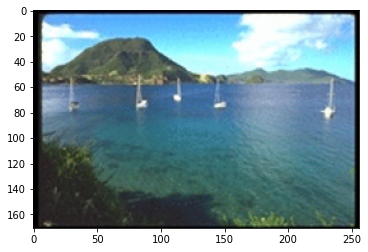

239.0625


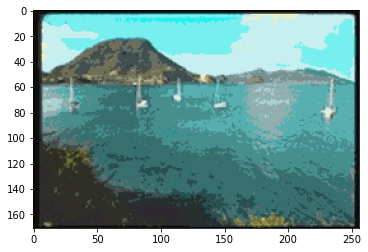

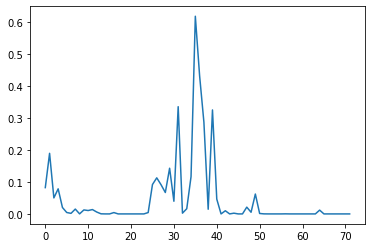

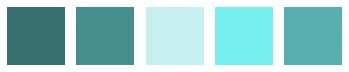

[(1, 1, 3), (1, 1, 4), (1, 0, 7), (1, 1, 7), (1, 1, 5)]


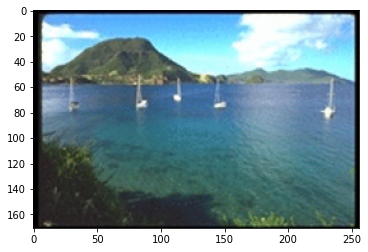

239.0625


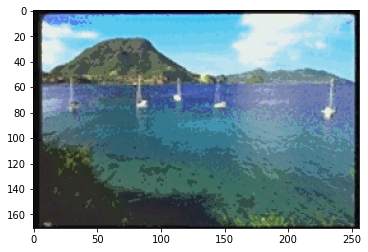

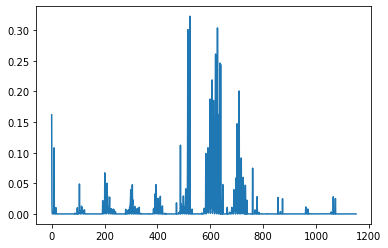

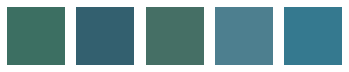

[(5, 5, 3), (6, 6, 3), (5, 4, 3), (6, 5, 4), (6, 7, 4)]


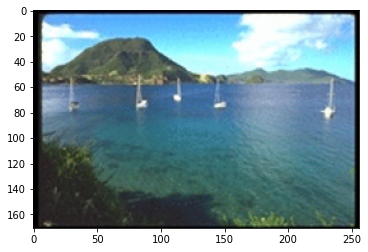

212.49999999999997


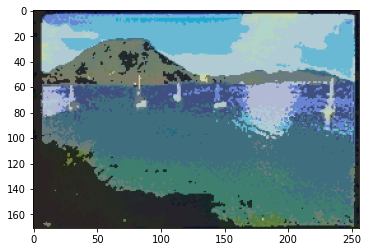

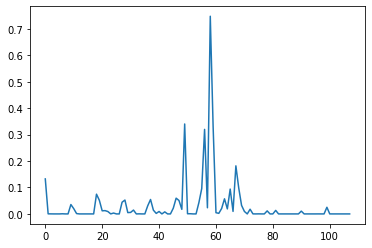

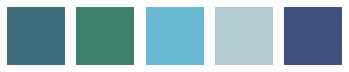

[(6, 1, 1), (5, 1, 1), (6, 1, 2), (6, 0, 2), (7, 1, 1)]


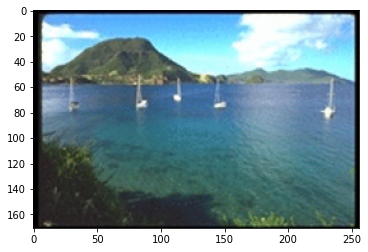

248.625


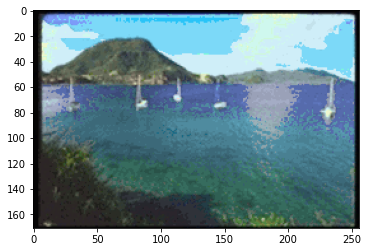

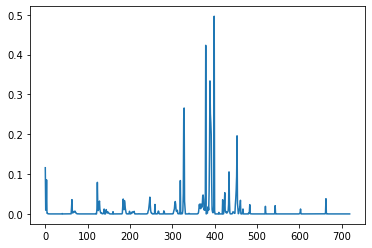

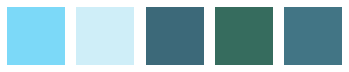

[(6, 1, 19), (6, 0, 19), (6, 1, 9), (5, 1, 8), (6, 1, 10)]


In [61]:
HSV(3,3,8,'./Base/','Paysages67.png')
HSV(12,12,8,'./Base/','Paysages67.png')
HSV(12,3,3,'./Base/','Paysages67.png')
HSV(12,3,20,'./Base/','Paysages67.png')

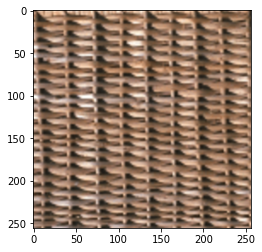

239.0625


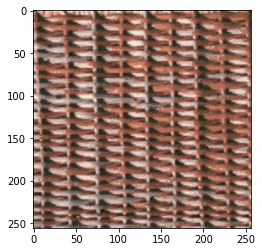

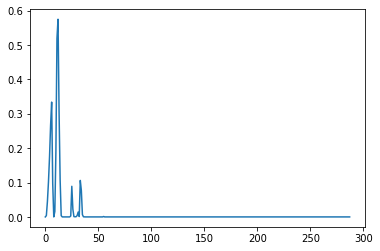

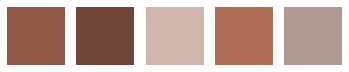

[(0, 1, 4), (0, 1, 3), (0, 0, 6), (0, 1, 5), (0, 0, 5)]


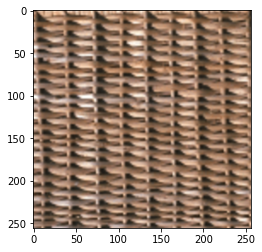

239.0625


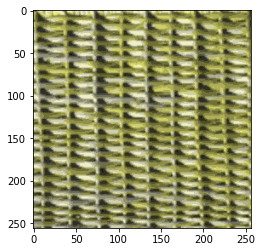

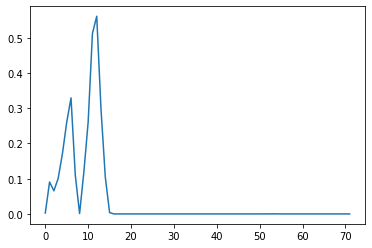

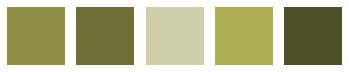

[(0, 1, 4), (0, 1, 3), (0, 0, 6), (0, 1, 5), (0, 1, 2)]


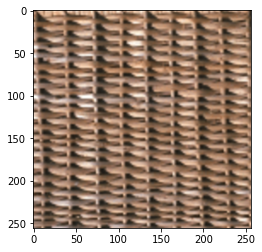

239.0625


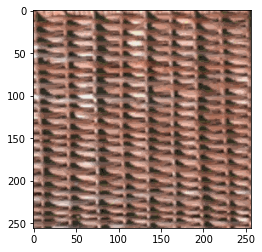

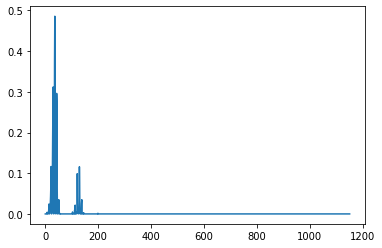

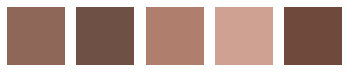

[(0, 4, 4), (0, 4, 3), (0, 4, 5), (0, 3, 6), (0, 5, 3)]


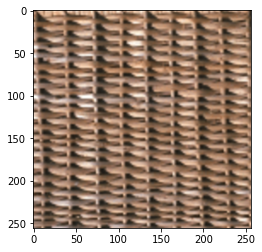

212.49999999999997


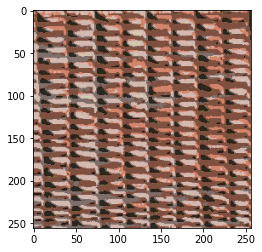

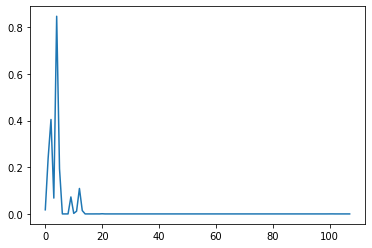

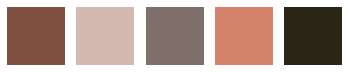

[(0, 1, 1), (0, 0, 2), (0, 0, 1), (0, 1, 2), (1, 1, 0)]


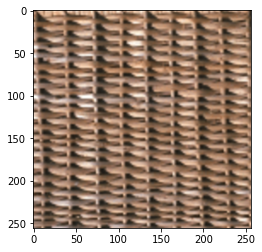

248.625


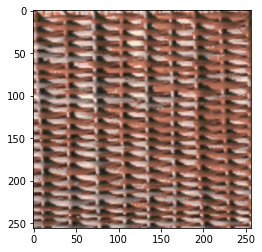

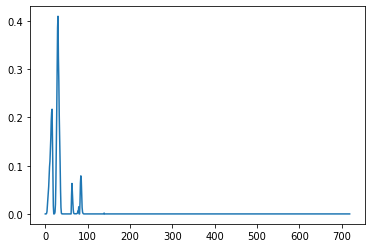

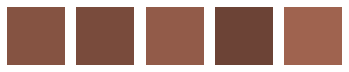

[(0, 1, 10), (0, 1, 9), (0, 1, 11), (0, 1, 8), (0, 1, 12)]


In [62]:
HSV(12,3,8,'./Base/','Textures47.png')
HSV(3,3,8,'./Base/','Textures47.png')
HSV(12,12,8,'./Base/','Textures47.png')
HSV(12,3,3,'./Base/','Textures47.png')
HSV(12,3,20,'./Base/','Textures47.png')

7) What can you say about the results?

Your answer: We observe that by changing the values nH, nS and nV, we obtain overall histograms whose peaks are located at the same place, however by strongly changing some of these values, the height of these peaks can vary a lot. Moreover if we take higher values for nH, nS or nV, we obtain many small peaks at the same place. Conversely, if we reduce these values, we obtain few peaks for a single place in the histogram. This is perfectly logical since nH, nS and nV correspond to the number of intervals that one takes for the values of H, S and V. We also observe that by taking too low values, the image is much modified . So you have to be careful when choosing these values because too low values cause a lot of loss of information on the image you are observing. On the other hand, too high values will not modify the image very much but the method we use afterwards will probably not work very well because by having too precise values, the algorithm may not be able to properly recognize the similarities between the images.

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [43]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
listImage = os.listdir(pathImage)
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = 1 # Set to False to compute the histogramm database

if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [63]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def similarityMatrix(listHisto):
    res=np.zeros((1040,1040))
    for i in range(len(listHisto)):
        for j in range(len(listHisto)):
             res[i,j]=np.linalg.norm(listHisto[i]-listHisto[j])
    return  res

S=similarityMatrix(listHisto)
print(S)

[[0.         1.0044728  0.81515417 ... 1.37971591 1.39195801 1.29859511]
 [1.0044728  0.         1.18642259 ... 1.39308401 1.40515952 1.30191945]
 [0.81515417 1.18642259 0.         ... 1.30326759 1.33965556 1.24121481]
 ...
 [1.37971591 1.39308401 1.30326759 ... 0.         1.06942716 1.39709654]
 [1.39195801 1.40515952 1.33965556 ... 1.06942716 0.         1.40351671]
 [1.29859511 1.30191945 1.24121481 ... 1.39709654 1.40351671 0.        ]]


2. Display the matrix `S`  as an image. What can we say about this it ?

Your answer: First, we see that the matrix is symmetrical, which is logical because comparing an img1 image with an img2 image is the same as comparing img2 with img1. We also see very clearly a black diagonal in the matrix, this diagonal corresponds to the cases where an image is compared with itself, this diagonal shows us that the distance between an image compared with itself is null. Finally, we notice dark squares along the diagonal in the matrix display, this is due to the fact that the images are arranged in a specific order in the database and that globally the images that look alike are arranged together (for example, the lion images are arranged right next to the other lion images since the images are in alphabetical order). We can also notice some squares far from the diagonal, by repeating the same reasoning concerning the way the images are arranged, we can conclude from the dark squares far from the diagonal that this method confuses some categories of images with other categories of images.

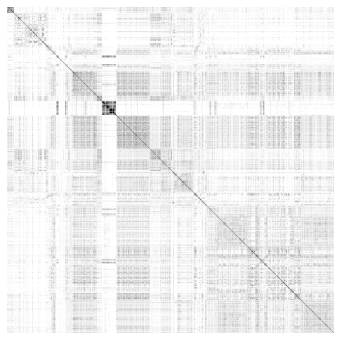

In [40]:
imshow(S)

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

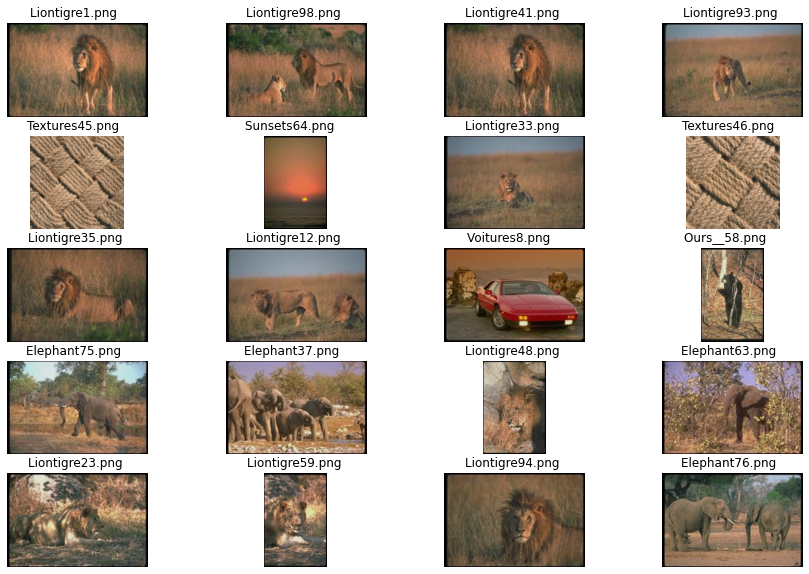

In [48]:
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


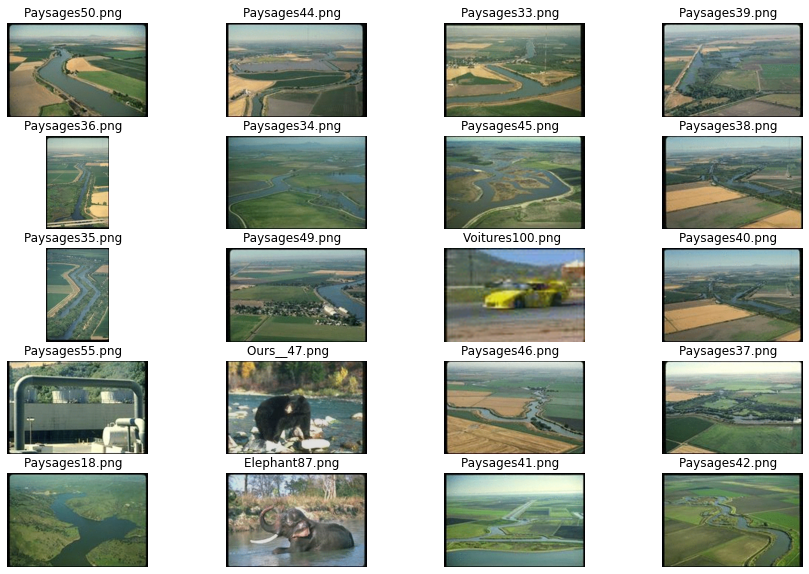

In [50]:
import random

display20bestMatches(S, random.randint(0,1030))
imageName = (pathImage+NomImageBase[indexQuery]).strip()

5. What can you say about the results ? What are the limitations and the advantages of this method ?

Your answer: This method works quite well on very similar images, as can be seen with the image of the lion in question 4. Indeed in this example a large part of the similar images that are returned are indeed lions. However, the main disadvantage of this method is that it only takes into account the colors of the pixels but not their positions in the image. As a result, even if 2 images correspond to very different things, if the colors are very close, then it will consider that they are similar. 